# Исследование влияния значений гиперпараметров на метрики качества обученной нейронной сети

**Проведите серию экспериментов по перебору гиперпараметров нейронной сети, созданной на занятии.**

1. Поменяйте количество нейронов в сети, используя следующие значения:

    - один слой 10 нейронов
    - один слой 100 нейронов
    - один слой 5000 нейронов

2. Поменяйте активационную функцию в скрытых слоях с `relu` на `linear`.

3. Поменяйте размеры `batch_size`:

    - 1
    - 10
    - 100
    - Вся база (60000)

4. Запишите в таблицу получившиеся точности.

5. Напишите выводы по результатам проведенных тестов.

In [1]:
from pathlib import Path
from typing import Any, Tuple

import numpy as np
import pandas as pd

from sklearn.metrics import classification_report

from tensorflow.keras.callbacks import History
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import utils

from PIL import Image

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
try:
    from collections.abc import Iterable
except ImportError:
    from collections import Iterable

Количество эпох обучения:

In [3]:
EPOCHS = 15

Метрики качества:

In [4]:
precision = Precision()
recall = Recall()

Создать датафрейм для хранения результатов тестирования.

In [5]:
report = pd.DataFrame(
    index=pd.MultiIndex.from_tuples([], names=("Категория", "Значение")),
    columns=['loss', 'accuracy', 'precision', 'recall', 'f1']
)

## Подготовка данных

Загрузка данных MNIST

In [6]:
(x_train_org, y_train_org), (x_test_org, y_test_org) =\
    mnist.load_data()

In [7]:
print(x_train_org.shape)

(60000, 28, 28)


Контрольное отображение цифр из набора

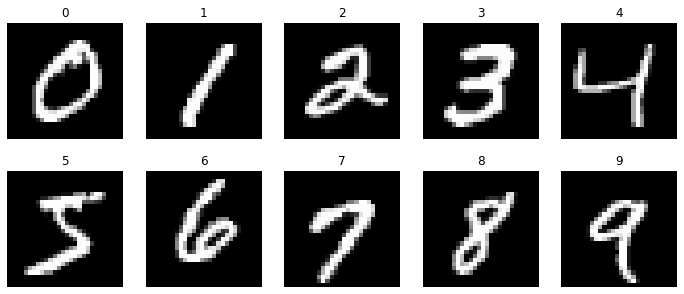

In [8]:
digits = np.unique(y_train_org)

_, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for digit, ax in zip(digits, axes):
    ax.imshow(
        Image.fromarray(x_train_org[y_train_org == digit][0]).convert('RGB')
    )

    ax.set_title(str(digit))
    ax.set_axis_off()

plt.show();

Изменить формат входных изображений

In [9]:
x_train = x_train_org.reshape(-1, 28*28).astype(np.float32) / 255
x_test = x_test_org.reshape(-1, 28*28).astype(np.float32) / 255

Преобразовать ответы в унитарный код (one-hot)

In [10]:
y_train = utils.to_categorical(y_train_org, 10)
y_test = utils.to_categorical(y_test_org, 10)

In [11]:
print(y_train.shape)

(60000, 10)


## Создание модели нейронной сети.

Определение вспомогательного класса для создания модели нейронной сети.

In [12]:
class NetBuilder:

    @staticmethod
    def build(layers: Tuple[int, ...], activation: str='relu') -> Sequential:
        if not layers or not isinstance(layers, Iterable):
            raise RuntimeError(f"Illegal layers collection {layers}")

        model = Sequential()
        # Добавить скрытые слои нейронной сети
        for i, n in enumerate(layers):
            if i == 0:
                layer = Dense(
                    n, input_dim=28*28, activation=activation
                )
            else:
                layer = Dense(
                    n, activation=activation
                )
            model.add(layer)

        # Добавить выходной слой нейронной сети
        model.add(
            Dense(10, activation='softmax')
        )

        return model

## 1. Ислледование влияния числа нейронов в скрытом слое

### 1.1. Число нейронов в скрытом слое 10

Создание модели нейронной сети с 10 нейронами в скрытом слое.

In [13]:
model_n10 = NetBuilder.build(layers=(800, 10))
model_n10.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', precision, recall]
)

print(model_n10.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 800)               628000    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                8010      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
Total params: 636,120
Trainable params: 636,120
Non-trainable params: 0
_________________________________________________________________
None


Обучение нейронной сети.

In [14]:
history_n10 = model_n10.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
469/469 [==============================] - 4s 8ms/step - loss: 0.3536 - accuracy: 0.8942 - precision: 0.9529 - recall: 0.8502
Epoch 2/15
469/469 [==============================] - 4s 8ms/step - loss: 0.1098 - accuracy: 0.9675 - precision: 0.9743 - recall: 0.9619
Epoch 3/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0713 - accuracy: 0.9792 - precision: 0.9829 - recall: 0.9760
Epoch 4/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0504 - accuracy: 0.9850 - precision: 0.9875 - recall: 0.9829
Epoch 5/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0366 - accuracy: 0.9892 - precision: 0.9908 - recall: 0.9876
Epoch 6/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0287 - accuracy: 0.9916 - precision: 0.9927 - recall: 0.9904
Epoch 7/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0208 - accuracy: 0.9940 - precision: 0.9947 - recall: 0.9934
Epoch 8/15
469/469 [=====================

Отобразить изменение loss и метрик качества в процессе обучения.

In [15]:
def plot_history(history: History):
    _, axes = plt.subplots(2, 2, figsize=(12, 12))

    axes = axes.flatten()

    axes[0].plot(
        history.epoch,
        history.history['loss'],
        color='steelblue'
    )
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[0].grid(True)

    axes[1].plot(
        history.epoch,
        history.history['accuracy'],
        color='salmon'
    )
    axes[1].set_ylabel('accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].grid(True)

    axes[2].plot(
        history.epoch,
        history.history['precision'],
        color='seagreen'
    )
    axes[2].set_ylabel('precision')
    axes[2].set_xlabel('epoch')
    axes[2].grid(True)

    axes[3].plot(
        history.epoch,
        history.history['recall'],
        color='cadetblue'
    )
    axes[3].set_ylabel('recall')
    axes[3].set_xlabel('epoch')
    axes[3].grid(True)

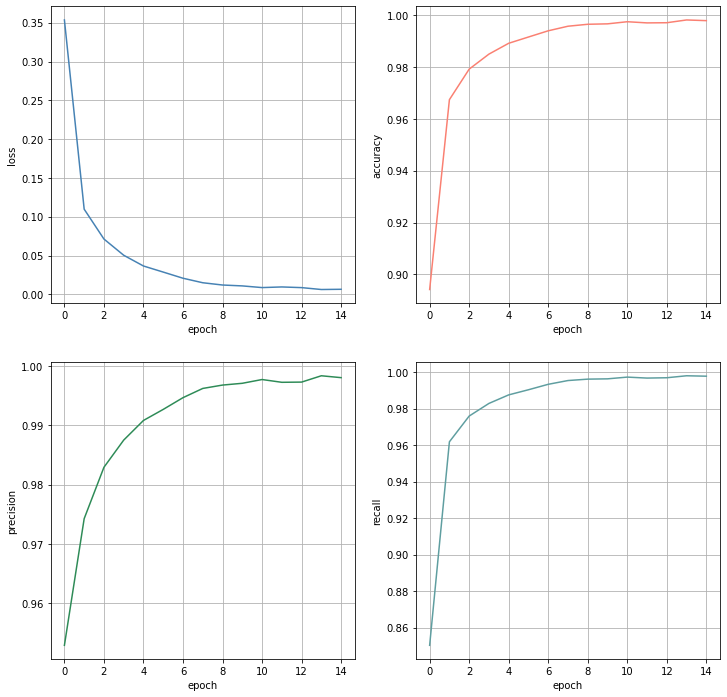

In [16]:
plot_history(history_n10)
plt.show();

Сохранить и загрузить веса нейронной сети.

In [17]:
path = Path.home() / 'aiu-01-mnist-light-model-n10.h5'

model_n10.save_weights(path)
model_n10.load_weights(path)

Оценить loss и метрики качества на тестовой выборке.

In [18]:
def update_report(model: Sequential, category: str, value: Any):
    score = model.evaluate(x_test, y_test, verbose=0)

    print(f"\nTest score: {score[0]}")
    print(f"Test accuracy: {score[1]}")
    print(f"Test precision: {score[2]}")
    print(f"Test recall: {score[3]}\n")

    report.loc[(category, value), :] = (
        score[0],
        score[1],
        score[2],
        score[3],
        2 * score[2] * score[3] / (score[2] + score[3])
    )

    y_pred_org = np.argmax(
        model.predict(x_test, verbose=0),
        axis=-1
    )
    print(classification_report(y_test_org, y_pred_org))

In [19]:
update_report(model_n10, "Число нейронов", 10)


Test score: 0.10296329110860825
Test accuracy: 0.9767000079154968
Test precision: 0.9776709675788879
Test recall: 0.9764000177383423

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.99      0.97      0.98      1010
           4       0.95      0.99      0.97       982
           5       0.97      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.99      0.97      0.98      1028
           8       0.96      0.99      0.98       974
           9       0.99      0.92      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### 1.2. Число нейронов в скрытом слое 100

Создание модели нейронной сети с 100 нейронами в скрытом слое.

In [20]:
model_n100 = NetBuilder.build(layers=(800, 100))
model_n100.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', precision, recall]
)

print(model_n100.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 800)               628000    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               80100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 709,110
Trainable params: 709,110
Non-trainable params: 0
_________________________________________________________________
None


Обучение нейронной сети.

In [21]:
history_n100 = model_n100.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
469/469 [==============================] - 4s 9ms/step - loss: 0.2215 - accuracy: 0.9350 - precision: 0.9593 - recall: 0.9230
Epoch 2/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0827 - accuracy: 0.9750 - precision: 0.9787 - recall: 0.9711
Epoch 3/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0512 - accuracy: 0.9837 - precision: 0.9858 - recall: 0.9824
Epoch 4/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0343 - accuracy: 0.9894 - precision: 0.9905 - recall: 0.9882
Epoch 5/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0261 - accuracy: 0.9917 - precision: 0.9927 - recall: 0.9909
Epoch 6/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0189 - accuracy: 0.9939 - precision: 0.9944 - recall: 0.9936
Epoch 7/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0165 - accuracy: 0.9945 - precision: 0.9950 - recall: 0.9941
Epoch 8/15
469/469 [=====================

Отобразить изменение loss и метрик качества в процессе обучения.

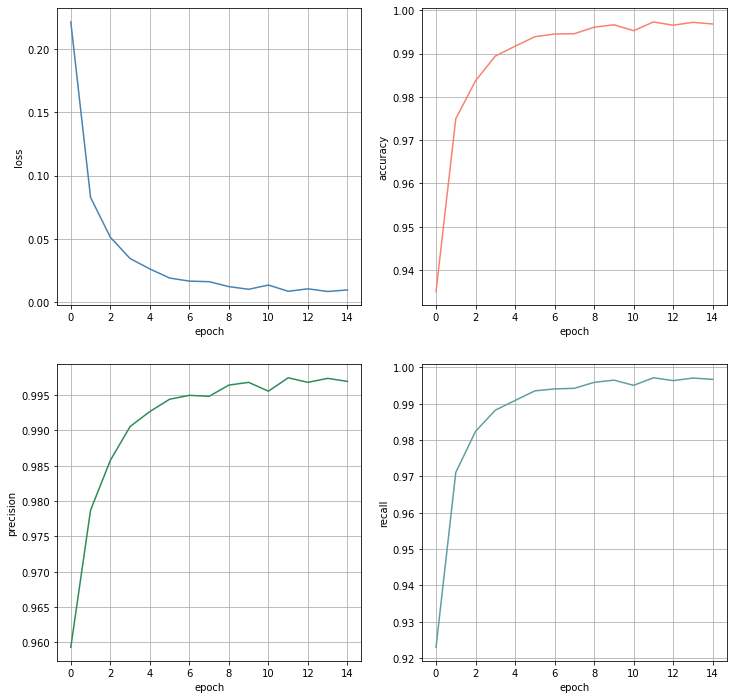

In [22]:
plot_history(history_n100)
plt.show();

Сохранить и загрузить веса нейронной сети.

In [23]:
path = Path.home() / 'aiu-01-mnist-light-model-n100.h5'

model_n100.save_weights(path)
model_n100.load_weights(path)

Оценить loss и метрики качества на тестовой выборке.

In [24]:
update_report(model_n100, "Число нейронов", 100)


Test score: 0.082186758518219
Test accuracy: 0.982699990272522
Test precision: 0.9830763339996338
Test recall: 0.9817000031471252

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### 1.3. Число нейронов в скрытом слое 5000

Создание модели нейронной сети с 5000 нейронами в скрытом слое.

In [25]:
model_n5000 = NetBuilder.build(layers=(800, 5000))
model_n5000.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', precision, recall]
)

print(model_n5000.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 800)               628000    
_________________________________________________________________
dense_7 (Dense)              (None, 5000)              4005000   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                50010     
Total params: 4,683,010
Trainable params: 4,683,010
Non-trainable params: 0
_________________________________________________________________
None


Обучение нейронной сети.

In [26]:
history_n5000 = model_n5000.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
469/469 [==============================] - 34s 72ms/step - loss: 0.1860 - accuracy: 0.9417 - precision: 0.9611 - recall: 0.9369
Epoch 2/15
469/469 [==============================] - 34s 72ms/step - loss: 0.0737 - accuracy: 0.9772 - precision: 0.9804 - recall: 0.9749
Epoch 3/15
469/469 [==============================] - 32s 68ms/step - loss: 0.0495 - accuracy: 0.9852 - precision: 0.9869 - recall: 0.9837
Epoch 4/15
469/469 [==============================] - 32s 68ms/step - loss: 0.0388 - accuracy: 0.9874 - precision: 0.9885 - recall: 0.9863
Epoch 5/15
469/469 [==============================] - 32s 69ms/step - loss: 0.0309 - accuracy: 0.9902 - precision: 0.9910 - recall: 0.9894
Epoch 6/15
469/469 [==============================] - 33s 71ms/step - loss: 0.0283 - accuracy: 0.9910 - precision: 0.9916 - recall: 0.9905
Epoch 7/15
469/469 [==============================] - 35s 74ms/step - loss: 0.0230 - accuracy: 0.9926 - precision: 0.9932 - recall: 0.9922
Epoch 8/15
469/469 [=======

Отобразить изменение loss и метрик качества в процессе обучения.

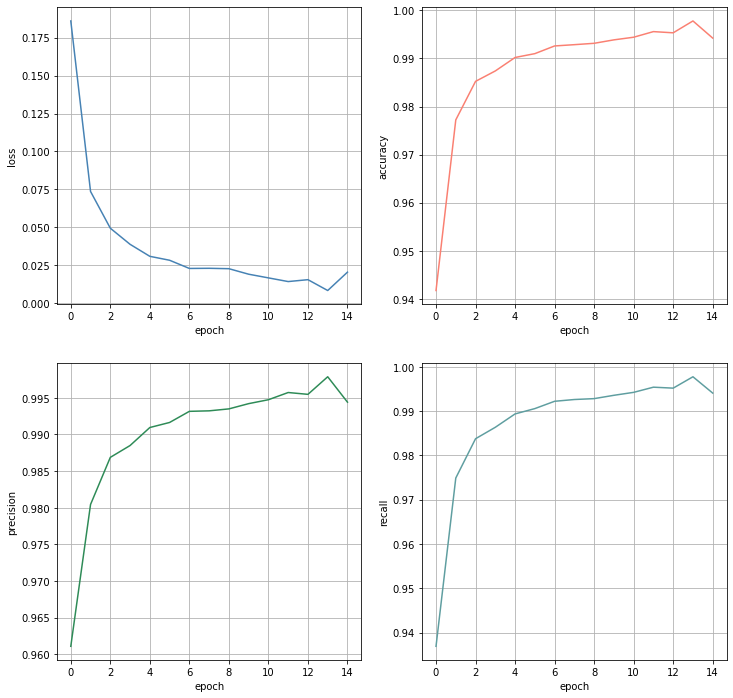

In [27]:
plot_history(history_n5000)
plt.show();

Сохранить и загрузить веса нейронной сети.

In [28]:
path = Path.home() / 'aiu-01-mnist-light-model-n5000.h5'

model_n5000.save_weights(path)
model_n5000.load_weights(path)

Оценить loss и метрики качества на тестовой выборке.

In [29]:
update_report(model_n5000, "Число нейронов", 5000)


Test score: 0.12449506670236588
Test accuracy: 0.9782999753952026
Test precision: 0.9797574877738953
Test recall: 0.9776999950408936

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.95      0.99      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.97      0.98      0.97       892
           6       0.98      0.98      0.98       958
           7       0.96      0.99      0.97      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## 2. Исследование влияния замены функции активации

Создание модели нейронной сети с активационной функцией `linear` в скрытых слоях.

In [30]:
model_linear = NetBuilder.build(layers=(800, 400), activation='linear')
model_linear.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', precision, recall]
)

print(model_linear.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 800)               628000    
_________________________________________________________________
dense_10 (Dense)             (None, 400)               320400    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                4010      
Total params: 952,410
Trainable params: 952,410
Non-trainable params: 0
_________________________________________________________________
None


Обучение нейронной сети.

In [31]:
history_linear = model_linear.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
469/469 [==============================] - 7s 15ms/step - loss: 0.3937 - accuracy: 0.8886 - precision: 0.9214 - recall: 0.8854
Epoch 2/15
469/469 [==============================] - 7s 15ms/step - loss: 0.3295 - accuracy: 0.9073 - precision: 0.9237 - recall: 0.8938
Epoch 3/15
469/469 [==============================] - 7s 15ms/step - loss: 0.3119 - accuracy: 0.9124 - precision: 0.9284 - recall: 0.8988
Epoch 4/15
469/469 [==============================] - 7s 15ms/step - loss: 0.3027 - accuracy: 0.9153 - precision: 0.9306 - recall: 0.9024
Epoch 5/15
469/469 [==============================] - 7s 15ms/step - loss: 0.2968 - accuracy: 0.9163 - precision: 0.9324 - recall: 0.9028
Epoch 6/15
469/469 [==============================] - 8s 17ms/step - loss: 0.2904 - accuracy: 0.9184 - precision: 0.9327 - recall: 0.9054
Epoch 7/15
469/469 [==============================] - 7s 15ms/step - loss: 0.2894 - accuracy: 0.9188 - precision: 0.9338 - recall: 0.9062
Epoch 8/15
469/469 [==============

Отобразить изменение loss и метрик качества в процессе обучения.

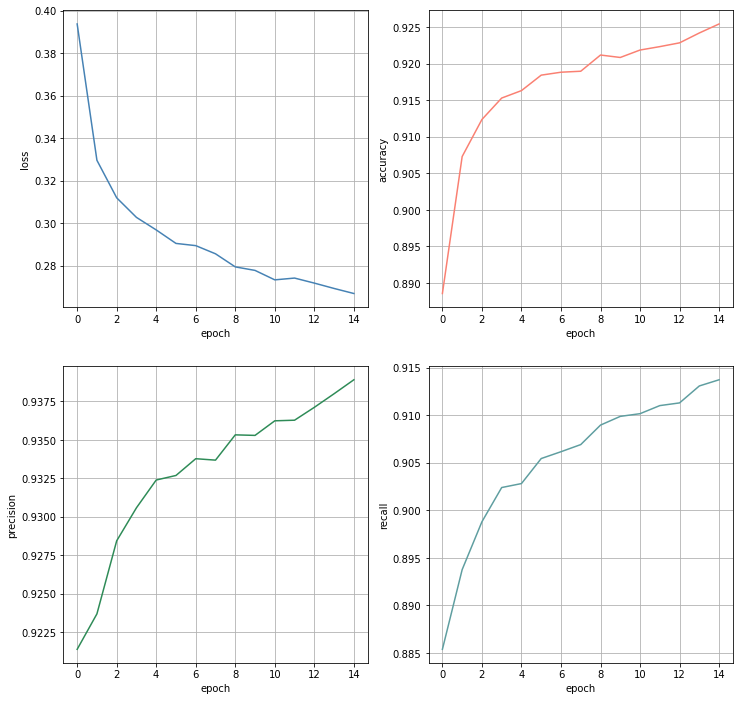

In [32]:
plot_history(history_linear)
plt.show();

Сохранить и загрузить веса нейронной сети.

In [33]:
path = Path.home() / 'aiu-01-mnist-light-model-linear.h5'

model_linear.save_weights(path)
model_linear.load_weights(path)

Оценить loss и метрики качества на тестовой выборке.

In [34]:
update_report(model_linear, "Функция активации", 'linear')


Test score: 0.29098108410835266
Test accuracy: 0.9211999773979187
Test precision: 0.9348049163818359
Test recall: 0.9104999899864197

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.92      0.91      0.92      1032
           3       0.91      0.89      0.90      1010
           4       0.93      0.93      0.93       982
           5       0.82      0.91      0.86       892
           6       0.94      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.89      0.84      0.87       974
           9       0.92      0.91      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



## 3. Исследование влияния размера пакета (батча)

### 3.1. Размер пакета равен 1

Создание модели нейронной сети с активационной функцией `relu` в скрытых слоях.

In [35]:
model_bs1 = NetBuilder.build(layers=(800, 400))
model_bs1.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', precision, recall]
)

print(model_bs1.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 800)               628000    
_________________________________________________________________
dense_13 (Dense)             (None, 400)               320400    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                4010      
Total params: 952,410
Trainable params: 952,410
Non-trainable params: 0
_________________________________________________________________
None


Обучение нейронной сети.

In [36]:
history_bs1 = model_bs1.fit(
    x_train,
    y_train,
    batch_size=1,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
60000/60000 [==============================] - 357s 6ms/step - loss: 0.2827 - accuracy: 0.9272 - precision: 0.9400 - recall: 0.9149
Epoch 2/15
60000/60000 [==============================] - 375s 6ms/step - loss: 0.1954 - accuracy: 0.9551 - precision: 0.9628 - recall: 0.9494
Epoch 3/15
60000/60000 [==============================] - 384s 6ms/step - loss: 0.1769 - accuracy: 0.9631 - precision: 0.9703 - recall: 0.9575
Epoch 4/15
60000/60000 [==============================] - 374s 6ms/step - loss: 0.1589 - accuracy: 0.9667 - precision: 0.9733 - recall: 0.9619
Epoch 5/15
60000/60000 [==============================] - 368s 6ms/step - loss: 0.1495 - accuracy: 0.9705 - precision: 0.9767 - recall: 0.9666
Epoch 6/15
60000/60000 [==============================] - 333s 6ms/step - loss: 0.1486 - accuracy: 0.9721 - precision: 0.9786 - recall: 0.9680
Epoch 7/15
60000/60000 [==============================] - 316s 5ms/step - loss: 0.1488 - accuracy: 0.9720 - precision: 0.9809 - recall: 0.9676

Отобразить изменение loss и метрик качества в процессе обучения.

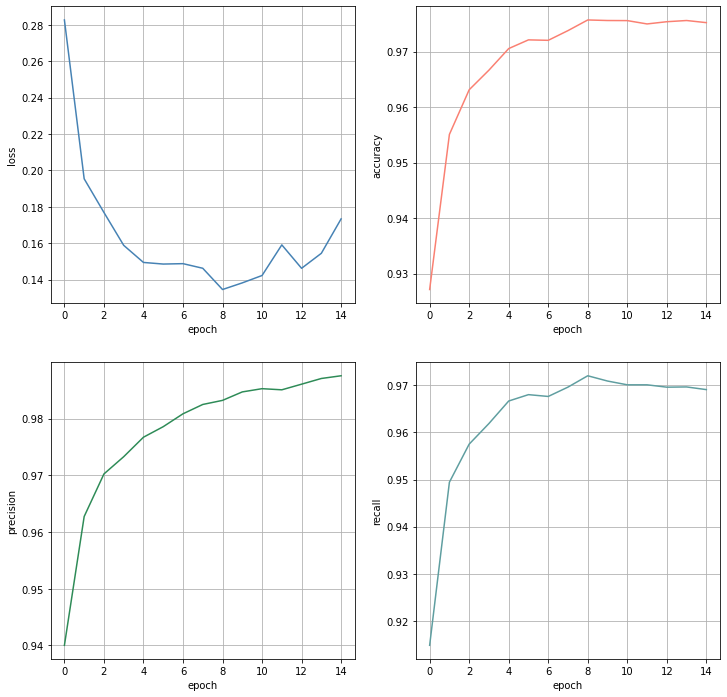

In [37]:
plot_history(history_bs1)
plt.show();

Сохранить и загрузить веса нейронной сети.

In [38]:
path = Path.home() / 'aiu-01-mnist-light-model-bs1.h5'

model_bs1.save_weights(path)
model_bs1.load_weights(path)

Оценить loss и метрики качества на тестовой выборке.

In [39]:
update_report(model_bs1, "Размер батча", 1)


Test score: 0.606475293636322
Test accuracy: 0.9664000272750854
Test precision: 0.9795211553573608
Test recall: 0.9613999724388123

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       980
           1       0.99      0.98      0.98      1135
           2       0.97      0.98      0.98      1032
           3       0.97      0.94      0.95      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.86      0.99      0.92       974
           9       0.98      0.93      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### 3.2. Размер пакета равен 10

Создание модели нейронной сети с активационной функцией `relu` в скрытых слоях.

In [40]:
model_bs10 = NetBuilder.build(layers=(800, 400))
model_bs10.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', precision, recall]
)

print(model_bs10.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 800)               628000    
_________________________________________________________________
dense_16 (Dense)             (None, 400)               320400    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                4010      
Total params: 952,410
Trainable params: 952,410
Non-trainable params: 0
_________________________________________________________________
None


Обучение нейронной сети.

In [41]:
history_bs10 = model_bs10.fit(
    x_train,
    y_train,
    batch_size=10,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
6000/6000 [==============================] - 41s 7ms/step - loss: 0.1877 - accuracy: 0.9430 - precision: 0.9589 - recall: 0.9367
Epoch 2/15
6000/6000 [==============================] - 46s 8ms/step - loss: 0.0941 - accuracy: 0.9717 - precision: 0.9750 - recall: 0.9689
Epoch 3/15
6000/6000 [==============================] - 44s 7ms/step - loss: 0.0691 - accuracy: 0.9795 - precision: 0.9818 - recall: 0.9778
Epoch 4/15
6000/6000 [==============================] - 42s 7ms/step - loss: 0.0564 - accuracy: 0.9841 - precision: 0.9856 - recall: 0.9829
Epoch 5/15
6000/6000 [==============================] - 42s 7ms/step - loss: 0.0485 - accuracy: 0.9858 - precision: 0.9868 - recall: 0.9849
Epoch 6/15
6000/6000 [==============================] - 42s 7ms/step - loss: 0.0403 - accuracy: 0.9878 - precision: 0.9888 - recall: 0.9871
Epoch 7/15
6000/6000 [==============================] - 44s 7ms/step - loss: 0.0362 - accuracy: 0.9903 - precision: 0.9910 - recall: 0.9899
Epoch 8/15
6000/6000

Отобразить изменение loss и метрик качества в процессе обучения.

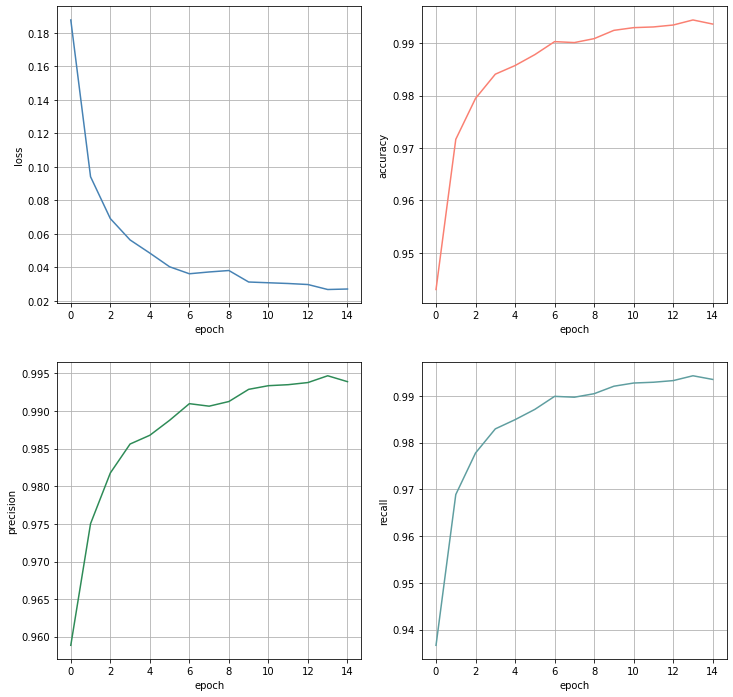

In [42]:
plot_history(history_bs10)
plt.show();

Сохранить и загрузить веса нейронной сети.

In [43]:
path = Path.home() / 'aiu-01-mnist-light-model-bs10.h5'

model_bs10.save_weights(path)
model_bs10.load_weights(path)

Оценить loss и метрики качества на тестовой выборке.

In [44]:
update_report(model_bs10, "Размер батча", 10)


Test score: 0.15894392132759094
Test accuracy: 0.9807999730110168
Test precision: 0.981381356716156
Test recall: 0.980400025844574

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97      0.97      1028
           8       0.96      0.98      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### 3.3. Размер пакета равен 100

Создание модели нейронной сети с активационной функцией `relu` в скрытых слоях.

In [45]:
model_bs100 = NetBuilder.build(layers=(800, 400))
model_bs100.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', precision, recall]
)

print(model_bs100.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 800)               628000    
_________________________________________________________________
dense_19 (Dense)             (None, 400)               320400    
_________________________________________________________________
dense_20 (Dense)             (None, 10)                4010      
Total params: 952,410
Trainable params: 952,410
Non-trainable params: 0
_________________________________________________________________
None


Обучение нейронной сети.

In [46]:
history_bs100 = model_bs100.fit(
    x_train,
    y_train,
    batch_size=100,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
600/600 [==============================] - 8s 13ms/step - loss: 0.1966 - accuracy: 0.9408 - precision: 0.9619 - recall: 0.9318
Epoch 2/15
600/600 [==============================] - 8s 13ms/step - loss: 0.0731 - accuracy: 0.9770 - precision: 0.9802 - recall: 0.9747
Epoch 3/15
600/600 [==============================] - 8s 13ms/step - loss: 0.0502 - accuracy: 0.9839 - precision: 0.9857 - recall: 0.9822
Epoch 4/15
600/600 [==============================] - 9s 14ms/step - loss: 0.0365 - accuracy: 0.9883 - precision: 0.9894 - recall: 0.9873
Epoch 5/15
600/600 [==============================] - 9s 15ms/step - loss: 0.0287 - accuracy: 0.9900 - precision: 0.9907 - recall: 0.9893
Epoch 6/15
600/600 [==============================] - 8s 14ms/step - loss: 0.0220 - accuracy: 0.9926 - precision: 0.9932 - recall: 0.9921
Epoch 7/15
600/600 [==============================] - 8s 14ms/step - loss: 0.0182 - accuracy: 0.9941 - precision: 0.9943 - recall: 0.9938
Epoch 8/15
600/600 [==============

Отобразить изменение loss и метрик качества в процессе обучения.

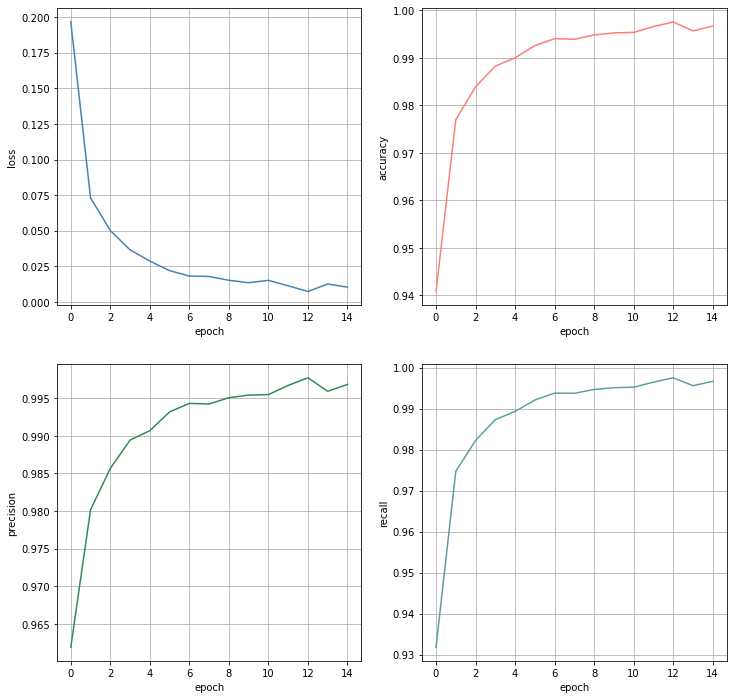

In [47]:
plot_history(history_bs100)
plt.show();

Сохранить и загрузить веса нейронной сети.

In [48]:
path = Path.home() / 'aiu-01-mnist-light-model-bs100.h5'

model_bs100.save_weights(path)
model_bs100.load_weights(path)

Оценить loss и метрики качества на тестовой выборке.

In [49]:
update_report(model_bs100, "Размер батча", 100)


Test score: 0.08476321399211884
Test accuracy: 0.9824000000953674
Test precision: 0.9828828573226929
Test recall: 0.9818999767303467

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.95      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.97      1.00      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.96      0.99      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### 3.4. Размер пакета равен 60000 (объему обучающей выборки)

Создание модели нейронной сети с активационной функцией `relu` в скрытых слоях.

In [50]:
model_bs_all = NetBuilder.build(layers=(800, 400))
model_bs_all.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', precision, recall]
)

print(model_bs_all.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 800)               628000    
_________________________________________________________________
dense_22 (Dense)             (None, 400)               320400    
_________________________________________________________________
dense_23 (Dense)             (None, 10)                4010      
Total params: 952,410
Trainable params: 952,410
Non-trainable params: 0
_________________________________________________________________
None


Обучение нейронной сети.

In [51]:
print(x_train.shape)

(60000, 784)


In [52]:
history_bs_all = model_bs_all.fit(
    x_train,
    y_train,
    batch_size=x_train.shape[0],
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
1/1 [==============================] - 0s 4ms/step - loss: 2.3360 - accuracy: 0.0904 - precision: 0.9829 - recall: 0.1403
Epoch 2/15
1/1 [==============================] - 0s 4ms/step - loss: 1.9220 - accuracy: 0.5375 - precision: 1.0000 - recall: 5.0000e-05
Epoch 3/15
1/1 [==============================] - 0s 3ms/step - loss: 1.5795 - accuracy: 0.7233 - precision: 0.9962 - recall: 0.0389
Epoch 4/15
1/1 [==============================] - 0s 3ms/step - loss: 1.2540 - accuracy: 0.7859 - precision: 0.9948 - recall: 0.1541
Epoch 5/15
1/1 [==============================] - 0s 2ms/step - loss: 0.9844 - accuracy: 0.8009 - precision: 0.9818 - recall: 0.3856
Epoch 6/15
1/1 [==============================] - 0s 4ms/step - loss: 0.7812 - accuracy: 0.8184 - precision: 0.9619 - recall: 0.5530
Epoch 7/15
1/1 [==============================] - 0s 5ms/step - loss: 0.6334 - accuracy: 0.8392 - precision: 0.9482 - recall: 0.6774
Epoch 8/15
1/1 [==============================] - 0s 3ms/step - l

Отобразить изменение loss и метрик качества в процессе обучения.

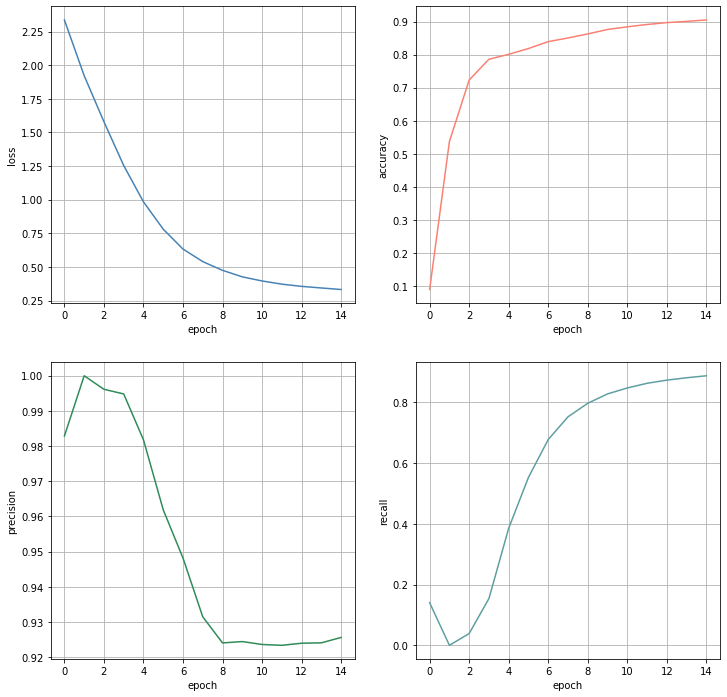

In [53]:
plot_history(history_bs_all)
plt.show();

Сохранить и загрузить веса нейронной сети.

In [54]:
path = Path.home() / 'aiu-01-mnist-light-model-bs-all.h5'

model_bs_all.save_weights(path)
model_bs_all.load_weights(path)

Оценить loss и метрики качества на тестовой выборке.

In [55]:
update_report(model_bs_all, "Размер батча", x_train.shape[0])


Test score: 0.3122881352901459
Test accuracy: 0.9121000170707703
Test precision: 0.9277818202972412
Test recall: 0.8980000019073486

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.97      0.98      0.97      1135
           2       0.91      0.89      0.90      1032
           3       0.89      0.90      0.89      1010
           4       0.91      0.93      0.92       982
           5       0.89      0.85      0.87       892
           6       0.94      0.93      0.93       958
           7       0.90      0.91      0.90      1028
           8       0.87      0.87      0.87       974
           9       0.90      0.88      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



## Выводы

Отобразим полученную таблицу с метриками качества

In [56]:
report

loss accuracy precision  recall        f1
Категория         Значение                                                
Число нейронов    10         0.102963   0.9767  0.977671  0.9764  0.977035
                  100       0.0821868   0.9827  0.983076  0.9817  0.982388
                  5000       0.124495   0.9783  0.979757  0.9777  0.978728
Функция активации linear     0.290981   0.9212  0.934805  0.9105  0.922492
Размер батча      1          0.606475   0.9664  0.979521  0.9614  0.970376
                  10         0.158944   0.9808  0.981381  0.9804   0.98089
                  100       0.0847632   0.9824  0.982883  0.9819  0.982391
                  60000      0.312288   0.9121  0.927782   0.898  0.912648

### 1. Оценка влияния числа нейронов на качество обучения нейронной сети

Отобразить столбчатую диаграмму значений метрик качества

In [57]:
query = report.xs("Число нейронов", level="Категория", axis=0, drop_level=True)

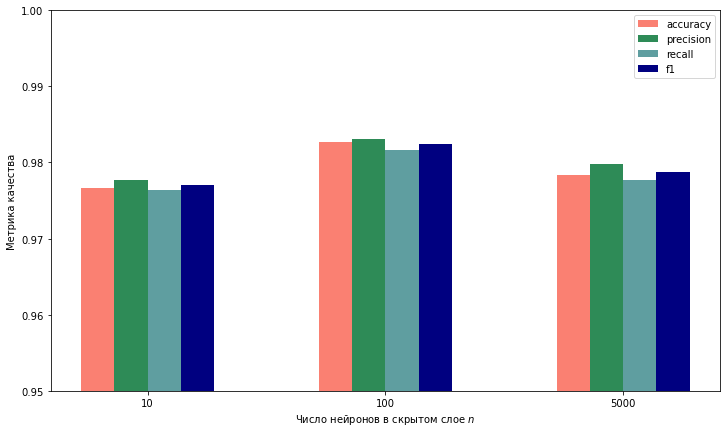

In [58]:
x = np.arange(len(query.index))
width = 0.14

_, ax = plt.subplots(figsize=(12, 7))

ax.bar(
    x - 3 * width / 2, 
    query.loc[:, 'accuracy'], 
    width, 
    color='salmon',
    label='accuracy'
)
ax.bar(
    x - width / 2, 
    query.loc[:, 'precision'], 
    width, 
    color='seagreen',
    label='precision'
)
ax.bar(
    x + width / 2, 
    query.loc[:, 'recall'], 
    width, 
    color='cadetblue',
    label='recall'
)
ax.bar(
    x + 3 * width / 2, 
    query.loc[:, 'f1'], 
    width, 
    color='navy',
    label='f1'
)

ax.set_ylabel("Метрика качества")
ax.set_ylim((0.95, 1.0))
ax.set_xlabel("Число нейронов в скрытом слое $n$")
ax.set_xticks(x)
ax.set_xticklabels(str(value) for value in query.index)
ax.legend()

plt.show();

Таким образом, можно сделать вывод, что с увеличением количества нейронов в скрытом слое значение метрик качества на тестовой выборке сначала увеличинается, потом уменьшается. Однако при количестве нейронов равном 5000, разница в значениях метрик качества на обучающей и тестовой выборках довольно значительна, что является первым признаком переобучения нейронной сети.

### 2. Оценка влияния замены функции активации на качество обучения нейронной сети

Данный эксперимент полностью подтвердил известный из теории факт, что использование линейных функций активации в многослойной нейронной сети фактически эквивалентно использованию однослойной нейронной сети, поскольку значения метрик качества ниже, чем у сети с такой же архитектурой, но использующей функцию активации `relu`.

### 3. Оценка влияния размера пакета (батча) на качество обучения нейронной сети

Отобразить столбчатую диаграмму значений метрик качества

In [59]:
query = report.xs("Размер батча", level="Категория", axis=0, drop_level=True)

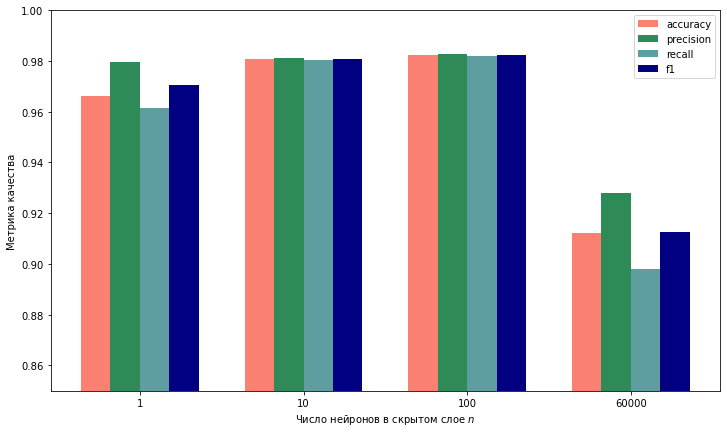

In [60]:
x = np.arange(len(query.index))
width = 0.18

_, ax = plt.subplots(figsize=(12, 7))

ax.bar(
    x - 3 * width / 2, 
    query.loc[:, 'accuracy'], 
    width, 
    color='salmon',
    label='accuracy'
)
ax.bar(
    x - width / 2, 
    query.loc[:, 'precision'], 
    width, 
    color='seagreen',
    label='precision'
)
ax.bar(
    x + width / 2, 
    query.loc[:, 'recall'], 
    width, 
    color='cadetblue',
    label='recall'
)
ax.bar(
    x + 3 * width / 2, 
    query.loc[:, 'f1'], 
    width, 
    color='navy',
    label='f1'
)

ax.set_ylabel("Метрика качества")
ax.set_ylim((0.85, 1.0))
ax.set_xlabel("Число нейронов в скрытом слое $n$")
ax.set_xticks(x)
ax.set_xticklabels(str(value) for value in query.index)
ax.legend()

plt.show();

На основании проделанных исследований можно сделать следующие выводы. Время обучения обратно пропорционально размеру батча и оно наиболшее, когда размер пакета равен 1 и наименьшее, когда размер пакета равен размеру обучающей выборки. Размер батча также влияет на метрики качества на тестовой выборке, как показывают результаты исследований, наихудшие результаты будут в случае, если объем батча равен объему обучающей выборки. Не следует делать также объем батча слишком маленьким.